# New Grid MCMC with Stellar Atmospheres

Started 29 October 2019. This notebook is meant to (finally) incorporate stellar atmospheres into the MCMC fit. Resampling is done in the actual MCMC to not have too many points. Let's see how this works. Interpolating the grid of stellar atmospheres onto the same grid as the points for fast computation.

### Imports

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct29 import *
from fu_ori_classes_oct29 import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl

import emcee
import corner
import time
%matplotlib inline 

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

In [3]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [4]:
def getDataArrayMOD(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(0,len(fulltxt), 2):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [5]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [6]:
direcToArray('/Users/tonyrodriguez/Documents/Docs/2019 Summer/Stellar Atmospheres/')

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

### Interpolating grid of stellar atmospheres on same grid as data:

First, reading in data...

In [7]:
txt_in = getDataArrayMOD('lkha_out.csv')
WAV_DAT = txt_in[:,0]
FLUX_DAT = txt_in[:,1]
FLUX_DAT_ERR = -0.01*FLUX_DAT

In [8]:
import spectres

In [9]:
def getInterpTable(st_atm_table, waves_data):
    out_table = dict()
    for key in ATM_TABLE:
        wav, lum = ATM_TABLE[key]
#         interp_func = interpolate.interp1d(wav, lum, kind = 'linear')
#         out_table[key] = waves_data, interp_func(waves_data)
        out_table[key] =  waves_data, spectres.spectres(waves_data, wav, lum)
    return out_table

In [10]:
WAVES_DATA_LOGGED = WAV_DAT

In [11]:
len(WAVES_DATA_LOGGED)

390

In [12]:
WAVES_DATA = 1e4*(10**WAVES_DATA_LOGGED)

In [13]:
ATM_TABLE_INTERP = getInterpTable(ATM_TABLE, WAVES_DATA)

In [14]:
ATM_TABLE_INTERP.keys()

dict_keys([(2000, 1.5), (2000, 4.0), (2100, 1.5), (2100, 4.0), (2200, 1.5), (2200, 4.0), (2300, 1.5), (2300, 4.0), (2400, 1.5), (2400, 4.0), (2500, 1.5), (2500, 4.0), (2600, 1.5), (2600, 4.0), (2700, 1.5), (2700, 4.0), (2800, 1.5), (2800, 4.0), (2900, 1.5), (2900, 4.0), (3000, 1.5), (3000, 4.0), (3100, 1.5), (3100, 4.0), (3200, 1.5), (3200, 4.0), (3300, 1.5), (3300, 4.0), (3400, 1.5), (3400, 4.0), (3500, 1.5), (3500, 4.0), (3600, 1.5), (3600, 4.0), (3700, 1.5), (3700, 4.0), (3800, 1.5), (3800, 4.0), (3900, 1.5), (3900, 4.0), (4000, 1.5), (4000, 4.0), (4100, 1.5), (4100, 4.0), (4200, 1.5), (4200, 4.0), (4300, 1.5), (4300, 4.0), (4400, 1.5), (4400, 4.0), (4500, 1.5), (4500, 4.0), (4600, 1.5), (4600, 4.0), (4700, 1.5), (4700, 4.0), (4800, 1.5), (4800, 4.0), (4900, 1.5), (4900, 4.0), (5000, 1.5), (5000, 4.0), (5100, 1.5), (5100, 4.0), (5200, 1.5), (5200, 4.0), (5300, 1.5), (5300, 4.0), (5400, 1.5), (5400, 4.0), (5500, 1.5), (5500, 4.0), (5600, 1.5), (5600, 4.0), (5700, 1.5), (5700, 4.0), (

In [15]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = 0
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, dist, grav, direc, a_v, atm_table):
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table)
        fuori.setAnnuliValues(10000, 2000, 200, 2*R_STAR)
        fuori.createAnnuliFromDirec(grav, direc, 'stellar atmospheres')
        fuori.createModelSpectrum('stellar atmospheres', False)
        self.fuori = fuori

### Making an instance of the class

In [73]:
M_STAR = 1.88*M_SUN
R_STAR= 4.78*R_SUN
R_OUTER = 200 * R_SUN
M_DOT = (10**-3.84) * M_SUN / 3.154e7

A_V = 7.85
INC = 45.
DIST = 920*3.08567758128e18
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

In [74]:
%time gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
%time gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC, a_v = A_V,dist = DIST, grav = 4.0, \
                                direc = DIREC, atm_table=ATM_TABLE_INTERP)

CPU times: user 62 µs, sys: 37 µs, total: 99 µs
Wall time: 103 µs
CPU times: user 2.71 ms, sys: 162 µs, total: 2.87 ms
Wall time: 2.81 ms


In [75]:
wav, lum = gaia17bpi_env.fuori.mod_spec_waves, gaia17bpi_env.fuori.mod_spec_lums
lum = pyasl.unred(wav, lum, -A_V/3.1)

In [76]:
gaia17bpi_env.fuori.annuli[0].temp, gaia17bpi_env.fuori.getTotalLum()/L_SUN

(9200.0, 850.6305275995547)

### Plotting data with model

In [77]:
6-1.52

4.48

In [78]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [79]:
model_wav = np.log10(wav*1e-4)
model_wav_flux =  np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2))

In [80]:
6 - 1.48

4.52

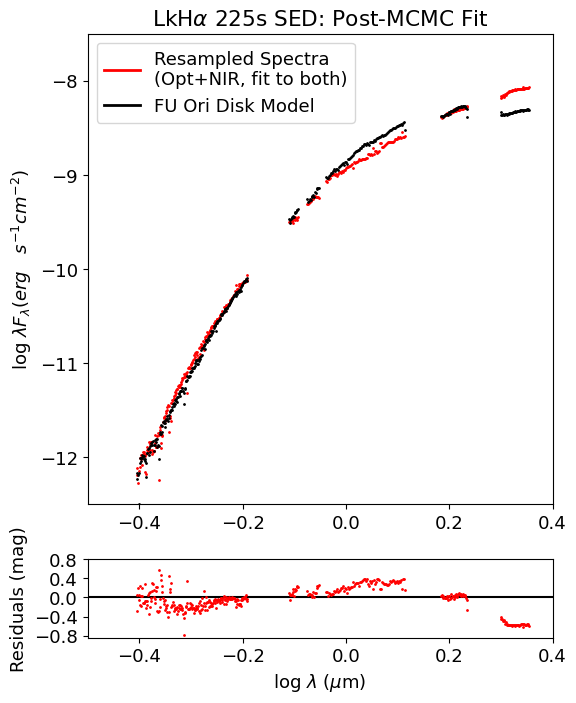

In [82]:
fig=plt.figure(figsize=(6, 8), dpi= 100)
gs = gridspec.GridSpec(2, 1,height_ratios=[3, 0.5])
plt.rcParams.update({'font.size': 13})

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax.plot(WAV_DAT, FLUX_DAT, 'ro', markersize=1, alpha=1)
ax.plot(model_wav,model_wav_flux, \
         'ko', markersize = 1)
ax2.axhline(0, color='k', alpha=1)
ax2.plot(model_wav, (1/0.4)*np.log10((10**model_wav_flux)/(10**FLUX_DAT)), 'ro', markersize=1)


# ax.text(0., -11, r'$M = 8.41M_\odot$''\n$R = 4.75R_\odot$'\
#         '\n$\dot{M} = 10^{-4.48} M_\odot yr^{-1}$''\n$i = 45^\circ$''\n$A_V = 7.87$')


ax2.set_xlabel(r'log $\lambda$ ($\mu$m)')
ax.set_ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
ax2.set_ylabel(r'Residuals (mag)')

ax.set_title(r'LkH$\alpha$ 225s SED: Post-MCMC Fit')
ax.set_ylim(-12.5, -7.5)
ax.set_xlim(-0.5, 0.4)
ax2.set_xlim(-0.5, 0.4)
ax2.set_yticks([-0.8, -0.4,0, 0.4,0.8])

legend_elements = [Line2D([0], [0], color='r', lw=2, label='Resampled Spectra\n(Opt+NIR, fit to both)'),
                   Line2D([0], [0], color='k', lw=2, label='FU Ori Disk Model')]
ax.legend(handles=legend_elements, loc='upper left')

# plt.savefig("LkHa225s_fit_both.png", dpi=200, bbox_inches='tight')
plt.show()

## MCMC Routine

In [117]:
def lnlike(theta, x, y, yerr):
    m_m_dot, r_star, a_v = theta
    r_star = r_star*R_SUN
    
    m_dot = 10**m_m_dot
    m_star = M_SUN
    
    m_dot = m_dot * M_SUN / 3.154e7
    try:
    
        gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                              m_dot = m_dot, inc = INC, a_v = a_v, dist = DIST, grav = 1.5, \
                                  direc = DIREC, atm_table=ATM_TABLE_INTERP)
    
    # Accounts for any random case where the model may not be generated properly given a certain combination
    # of parameters. This has only happened once, but it's presumably when the maximum temperature is too low.
    except:
        return 0
        print('Weird array error')
        gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
        gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                              m_dot = M_DOT, inc = INC, a_v = A_V, dist = DIST, grav = 1.5, \
                                  direc = DIREC, atm_table=ATM_TABLE_INTERP)
        
    
    # Converting units to properly compare model to data
    x_new = (10**x)*1e4
    modSpec = np.zeros(len(x_new))
    modSpec = gaia17bpi_env.fuori.mod_spec_lums
    modSpec = pyasl.unred(x_new, modSpec, -a_v/3.1)
    flux = np.cos(np.radians(INC))*modSpec/(2*np.pi*DIST**2)

    model = np.log10(x_new*flux*1e-8)
    inv_sig = 1/yerr
    return np.sum(np.log((1/np.sqrt(2*np.pi))*inv_sig) - 0.5*((y - model)*inv_sig)**2)

In [118]:
10**-4

0.0001

In [119]:
M_STAR_LOW = 0.5
M_STAR_HIGH = 15.0
R_STAR_LOW = 0.3
R_STAR_HIGH = 15.0

M_DOT_LOW = -1.5 - 6
M_DOT_HIGH = 3.5 - 6


A_V_LOW = 5
A_V_HIGH = 10.

In [120]:
def lnprior(theta):
    m_m_dot, r_star, a_v = theta
    if M_DOT_LOW  < m_m_dot < M_DOT_HIGH \
    and A_V_LOW < a_v < A_V_HIGH\
    and R_STAR_LOW < r_star < R_STAR_HIGH:
        return np.log(1/1.8691) +2.35*np.log(10**m_m_dot)
    return -np.inf

In [121]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + lnlike(theta, x, y, yerr))

In [147]:
ndim, nwalkers = 3, 16
m_star_start = 8
r_star_start = 5
m_dot_start = -3.6
a_v_start = 8
start = np.array((m_dot_start, r_star_start, a_v_start))
pos = [start + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [148]:
x = WAV_DAT
y_meas = FLUX_DAT
y_err = FLUX_DAT_ERR

In [149]:
len(WAV_DAT), len(gaia17bpi_env.fuori.mod_spec_lums)

(390, 390)

In [150]:
lnprob((m_dot_start, r_star_start, a_v_start), x,y_meas,y_err)

90.4877051429013

In [151]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_meas, y_err))
%time sampler.run_mcmc(pos, 6000, progress=True)

100%|██████████| 6000/6000 [04:01<00:00, 24.87it/s]

CPU times: user 3min 57s, sys: 7.45 s, total: 4min 4s
Wall time: 4min 1s


State([[-3.58011328  4.3810618   7.88339848]
 [-3.56239526  4.84064402  7.84146584]
 [-3.55977039  4.39734719  7.96512883]
 [-3.55781601  5.26442168  7.71616861]
 [-3.55594081  4.79024934  7.85031906]
 [-3.56382741  4.84001853  7.79174806]
 [-3.56204195  4.89487617  7.84142147]
 [-3.57278886  5.04811049  7.74181672]
 [-3.56957742  4.76909071  7.83864852]
 [-3.57827566  4.51457347  7.89104858]
 [-3.56777346  5.04591722  7.76959609]
 [-3.56689823  4.5448903   7.87645919]
 [-3.58056162  4.46114015  7.88212601]
 [-3.56732618  4.941703    7.7841262 ]
 [-3.57578298  4.43396247  7.91327689]
 [-3.5337692   4.68539515  7.96783632]], log_prob=[282.24198104 284.15342584 282.1797912  282.85470352 281.58377857
 281.52917156 283.50372145 282.23284053 283.60960298 283.01252072
 282.62979279 283.3950503  283.04952613 283.40229953 283.79840554
 280.73389508], blobs=None, random_state=('MT19937', array([3554288017,  821153612, 4114439907,  621334534, 1632910350,
       2294313152, 2842371097, 3073963285

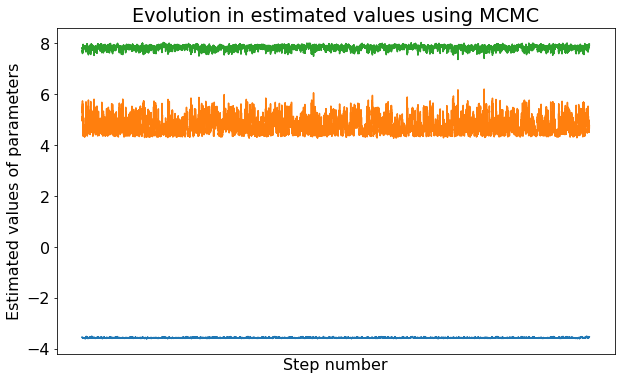

In [152]:
samples = sampler.chain[:, 3000:, :].reshape((-1, ndim))
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})

plt.plot(samples)
plt.xlabel('Step number')
plt.ylabel('Estimated values of parameters')
plt.title('Evolution in estimated values using MCMC')
plt.xticks([])
plt.show()

### Testing for Convergence

In [153]:
chain_test = sampler.chain[:, 3000:, :]

In [154]:
def convertToSteps(chains, param_num):
    chains_res = []
    for i in range(len(chain_test)):
        chains_res.append(chain_test[i][:,param_num])
    return np.array(chains_res)

In [155]:
def gelmanrubin(chains):
    M = chains.shape[0]
    N = chains.shape[1]
    thetaJ = np.mean(chains,axis =1)
    thetabar = np.mean(chains)
    sJ = np.zeros(M)
    for i in range(0,M):
        sJ[i] = 1./(N-1.0)*np.sum(np.power(chains[i,:]-thetaJ[i],2.))
    W = 1./float(M)*np.sum(sJ)
    B = float(N)/(M-1.)*np.sum(np.power(thetaJ-thetabar,2.0))
    vartheta = float(N-1)/float(N)*W +B/float(N)
    return np.sqrt(vartheta/W)

In [156]:
for i in range(3):
    print(gelmanrubin(convertToSteps(chain_test, i)))

1.0128891620483158
1.0158424219812534
1.0134855483901577


### Making corner plot

Quantiles:
[(0.16, -3.5749015168383913), (0.5, -3.5668443969874946), (0.84, -3.5558312453886542)]
Quantiles:
[(0.16, 4.471786056715973), (0.5, 4.728905986059959), (0.84, 5.090585731737482)]
Quantiles:
[(0.16, 7.761206810656688), (0.5, 7.853327345727182), (0.84, 7.915429824201681)]


/Users/tonyrodriguez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


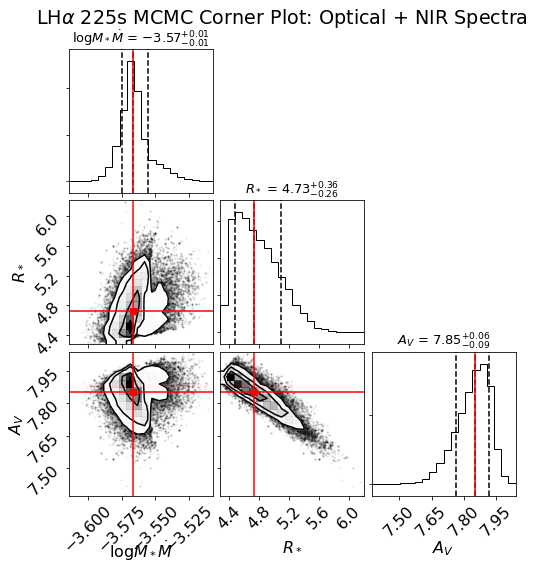

In [160]:
median_calcuated = np.median(samples, axis=0)
fig = corner.corner(samples, labels=[r'$ \log M_* \dot{M}$', r'$R_*$',r'$A_V$'], verbose=True,
                       quantiles=(0.16, 0.5,0.84), plot_contours=True, scale_hist=True,
                       show_titles=True, title_kwargs={"fontsize": 13})

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(median_calcuated[i], color="r")
    
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(median_calcuated[xi], color="r")
        ax.axhline(median_calcuated[yi], color="r")
        ax.plot(median_calcuated[xi], median_calcuated[yi], "sr")


fig.suptitle(r'LH$\alpha$ 225s MCMC Corner Plot: Optical + NIR Spectra', x=0.52, y=1.025)        
fig.show()

# fig.savefig("lkha225s_corner_m_mdot.png", dpi=200, bbox_inches='tight')

In [159]:
np.log10(2.74) - 4

-3.562249437179612